In [1]:
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2
import sqlalchemy
import os
import json

from dotenv import load_dotenv
load_dotenv()

import matplotlib as plt
%matplotlib inline

In [2]:
conn = psycopg2.connect(
    user=os.getenv("POSTGRES_USER"), 
    password=os.getenv("POSTGRES_PASSWORD"), 
    host="127.0.0.1", 
    port="54320", 
    database="dcat")

In [3]:
cur = conn.cursor()

In [4]:
print ( conn.get_dsn_parameters(),"\n")

{'user': 'dcat', 'dbname': 'dcat', 'host': '127.0.0.1', 'port': '54320', 'tty': '', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'} 



In [5]:
cur.execute("SELECT version();")
record = cur.fetchone()
print("You are connected to - ", record,"\n")

You are connected to -  ('PostgreSQL 12.0 (Debian 12.0-1.pgdg100+1) on x86_64-pc-linux-gnu, compiled by gcc (Debian 8.3.0-6) 8.3.0, 64-bit',) 



# Init

In [6]:
#Relationship description/attributes
cur.execute("delete from tbl_er_desc")
#Relationships/Edges
cur.execute("delete from tbl_er")
#Node details table
cur.execute("delete from tbl_detail")

conn.commit()

# Get data

In [7]:
xls = pd.ExcelFile("../data/testdata.xlsx")
xls.sheet_names

['Formål GML',
 'Formål',
 'Ark1',
 'data-catalog-backend',
 'data-catalog-policies',
 'Category']

# Populate tables

### Relationships

In [8]:
relationships = ["has purpose", "based on purpose", "has attribute", "attribute of","belongs to category", "contains concept"]
index = 1
for relationship in relationships:
    insert_query = f"insert into tbl_er_desc values ({index},'{relationship}')"
    cur.execute(insert_query)
    index += 1
    
conn.commit()

In [83]:
df_links = sqlio.read_sql_query("select * from tbl_er_desc", conn)
df_links

,id,info
0,1,has purpose
1,2,based on purpose
2,3,has attribute
3,4,attribute of
4,5,belongs to category
5,6,contains concept


### Processing activities

In [10]:
sheet=xls.sheet_names[1]
df_formål = pd.read_excel(xls, sheet, encoding='latin1')
df_formål = df_formål[['Forslag til endelig formålskode', 'Formålsbeskrivelse']]
df_formål.columns=['code', 'description']
df_formål['name'] = df_formål['code'].apply(lambda x: x.upper())
df_formål = df_formål.append({'name': 'NOT AVAILABLE', 'description': 'Not Available -Verdi mangler'}, ignore_index=True)
df_formål.drop(['code'], axis=1, inplace=True)
df_formål['type'] = 'prosessing activity'
df_formål.tail()

,description,name,type
33,Behandle og vurdere rett til uføretrygd som sk...,UFØRETRYGD,prosessing activity
34,Behandle og vurdere rett til ventelønn som ska...,VENTELØNN,prosessing activity
35,Behandle og vurdere rett til ytelser ved yrkes...,YRKESSKADE- OG SYKDOM,prosessing activity
36,Behandle og vurdere rett til ytelser til famil...,YTELSER TIL FAMILIEPLEIER,prosessing activity
37,Not Available -Verdi mangler,NOT AVAILABLE,prosessing activity


In [11]:
for index, row in df_formål.iterrows():
    id = index + 1
    jsonb = row.to_json()
    insert_query = f"insert into tbl_detail values ({id},'{jsonb}', now())"
    cur.execute(insert_query, (jsonb,))
    
conn.commit()

In [12]:
df = sqlio.read_sql_query("select * from tbl_detail", conn)
df.tail()

,id,info,crt_time
33,34,"{'name': 'UFØRETRYGD', 'type': 'prosessing act...",2019-10-09 07:16:19.797531
34,35,"{'name': 'VENTELØNN', 'type': 'prosessing acti...",2019-10-09 07:16:19.797531
35,36,"{'name': 'YRKESSKADE- OG SYKDOM', 'type': 'pro...",2019-10-09 07:16:19.797531
36,37,"{'name': 'YTELSER TIL FAMILIEPLEIER', 'type': ...",2019-10-09 07:16:19.797531
37,38,"{'name': 'NOT AVAILABLE', 'type': 'prosessing ...",2019-10-09 07:16:19.797531


### Purpose

In [13]:
df_purpose = df_formål.copy()
df_purpose['type'] = 'purpose'

In [14]:
cur.execute("select max(id) from tbl_detail")
index = cur.fetchone()[0]

for i, row in df_purpose.iterrows():
    index = index + 1
    jsonb = row.to_json()
    insert_query = f"insert into tbl_detail values ({index},'{jsonb}', now())"
    cur.execute(insert_query, (jsonb,))
    
conn.commit()

In [15]:
df = sqlio.read_sql_query("select * from tbl_detail", conn)
df.tail()

,id,info,crt_time
71,72,"{'name': 'UFØRETRYGD', 'type': 'purpose', 'des...",2019-10-09 07:16:22.788038
72,73,"{'name': 'VENTELØNN', 'type': 'purpose', 'desc...",2019-10-09 07:16:22.788038
73,74,"{'name': 'YRKESSKADE- OG SYKDOM', 'type': 'pur...",2019-10-09 07:16:22.788038
74,75,"{'name': 'YTELSER TIL FAMILIEPLEIER', 'type': ...",2019-10-09 07:16:22.788038
75,76,"{'name': 'NOT AVAILABLE', 'type': 'purpose', '...",2019-10-09 07:16:22.788038


### Legal basis

In [16]:
sheet=xls.sheet_names[4]
df_legal_basis = pd.read_excel(xls, sheet, encoding='latin1')
df_legal_basis = df_legal_basis[['legalBasisDescription']].drop_duplicates()
df_legal_basis.columns=['name']
df_legal_basis = df_legal_basis.append({'name': 'NOT AVAILABLE'}, ignore_index=True)
df_legal_basis['type'] = 'legal_basis'
df_legal_basis.head()

,name,type
0,Ftrl. § 11-20,legal_basis
1,"Ftrl. §§ 3-16, 3-24, 3-25, 20-8.",legal_basis
2,"Kapittel 3, 19, 20 0g 22",legal_basis
3,Ftrl § 3-2 og § 3-3,legal_basis
4,Barnetrygdloven § 9,legal_basis


In [17]:
cur.execute("select max(id) from tbl_detail")
index = cur.fetchone()[0]

for i, row in df_legal_basis.iterrows():
    index = index + 1
    jsonb = row.to_json()
    insert_query = f"insert into tbl_detail values ({index},'{jsonb}', now())"
    cur.execute(insert_query, (jsonb,))
    
conn.commit()

In [18]:
df = sqlio.read_sql_query("select * from tbl_detail", conn)
df.tail()

,id,info,crt_time
232,233,"{'name': '§ 22-1 og taushetsplikt', 'type': 'l...",2019-10-09 07:16:25.890380
233,234,"{'name': 'Kap 8. § 22-1, 22-13 og 22-15, taush...",2019-10-09 07:16:25.890380
234,235,"{'name': 'Fvl § 12 ', 'type': 'legal_basis'}",2019-10-09 07:16:25.890380
235,236,{'name': 'Det legges til grunn at Lgl + Lgf ka...,2019-10-09 07:16:25.890380
236,237,"{'name': 'NOT AVAILABLE', 'type': 'legal_basis'}",2019-10-09 07:16:25.890380


### Concepts

In [19]:
sheet=xls.sheet_names[3]

df_concepts = pd.read_excel(xls, sheet, encoding='latin1')
df_concepts = df_concepts[['title', 'description']]
df_concepts.columns=['name', 'description']
df_concepts['name'] = df_concepts['name'].apply(lambda x: x.strip().upper())
df_concepts = df_concepts.append({'name': 'NOT AVAILABLE', 'description': 'Not Available -Verdi mangler'}, ignore_index=True).drop_duplicates()
df_concepts['type'] = 'concept'
df_concepts.head()

,name,description,type
0,SIVILSTAND,En overordnet kategori som beskriver en person...,concept
1,ARBEIDSFORHOLD,"Avtaleforhold hvor den ene part, arbeidstakere...",concept
2,KJØNN,TODO - mangler i begrepskatalogen og i MFNs be...,concept
3,NAVN,I Norge skal alle ha fornavn og ett enkelt ell...,concept
4,FØDSELSDATO,Datoen personen er født.,concept


In [20]:
cur.execute("select max(id) from tbl_detail")
index = cur.fetchone()[0]

for i, row in df_concepts.iterrows():
    index = index + 1
    jsonb = row.to_json()
    insert_query = f"insert into tbl_detail values ({index},'{jsonb}', now())"
    cur.execute(insert_query, (jsonb,))
    
conn.commit()

In [21]:
df = sqlio.read_sql_query("select * from tbl_detail", conn)
df.tail()

,id,info,crt_time
253,233,"{'name': '§ 22-1 og taushetsplikt', 'type': 'l...",2019-10-09 07:16:25.890380
254,234,"{'name': 'Kap 8. § 22-1, 22-13 og 22-15, taush...",2019-10-09 07:16:25.890380
255,235,"{'name': 'Fvl § 12 ', 'type': 'legal_basis'}",2019-10-09 07:16:25.890380
256,236,{'name': 'Det legges til grunn at Lgl + Lgf ka...,2019-10-09 07:16:25.890380
257,237,"{'name': 'NOT AVAILABLE', 'type': 'legal_basis'}",2019-10-09 07:16:25.890380


### Categories

In [22]:
sheet=xls.sheet_names[3]
df_categories = pd.read_excel(xls, sheet, encoding='latin1')
df_categories = df_categories[['categories']]
df_categories.columns=['name']
df_categories['name'] = df_categories['name'].apply(lambda x: x.strip().upper())
df_categories = df_categories.append({'name': 'NOT AVAILABLE'}, ignore_index=True).drop_duplicates()
df_categories['type'] = 'category'
df_categories.head()

,name,type
0,PERSONALIA,category
1,ARBEIDSFORHOLD,category
6,KONTAKTOPPLYSNINGER,category
9,FAMILIERELASJONER,category
16,FOLKETRYGD,category


In [23]:
cur.execute("select max(id) from tbl_detail")
index = cur.fetchone()[0]

for i, row in df_categories.iterrows():
    index = index + 1
    jsonb = row.to_json()
    insert_query = f"insert into tbl_detail values ({index},'{jsonb}', now())"
    cur.execute(insert_query, (jsonb,))
    
conn.commit()

### Nodes

In [24]:
df_nodes = sqlio.read_sql_query("select * from tbl_detail", conn)
df_nodes['name'] = df_nodes['info'].apply(lambda x : x['name'])
df_nodes['type'] = df_nodes['info'].apply(lambda x : x['type'])
df_nodes.head()

,id,info,crt_time,name,type
0,238,"{'name': 'SIVILSTAND', 'type': 'concept', 'des...",2019-10-09 07:16:32.176532,SIVILSTAND,concept
1,239,"{'name': 'ARBEIDSFORHOLD', 'type': 'concept', ...",2019-10-09 07:16:32.176532,ARBEIDSFORHOLD,concept
2,240,"{'name': 'KJØNN', 'type': 'concept', 'descript...",2019-10-09 07:16:32.176532,KJØNN,concept
3,241,"{'name': 'NAVN', 'type': 'concept', 'descripti...",2019-10-09 07:16:32.176532,NAVN,concept
4,242,"{'name': 'FØDSELSDATO', 'type': 'concept', 'de...",2019-10-09 07:16:32.176532,FØDSELSDATO,concept


### Edges

In [66]:
sheet=xls.sheet_names[3]
df_edges = pd.read_excel(xls, sheet, encoding='latin1')
df_edges = df_edges[['title', 'categories']].drop_duplicates()
df_edges.columns = ['source', 'target']
df_edges['source'] = df_edges['source'].apply(lambda x: x.strip().upper())
df_edges['target'] = df_edges['target'].apply(lambda x: x.strip().upper())
df_edges.drop_duplicates()

df_edges.head()

,source,target
0,SIVILSTAND,PERSONALIA
1,ARBEIDSFORHOLD,ARBEIDSFORHOLD
2,KJØNN,PERSONALIA
3,NAVN,PERSONALIA
4,FØDSELSDATO,PERSONALIA


In [67]:
cur.execute("delete from tbl_er")
conn.commit()

for index, row in df_edges.iterrows():
    df_nodes.loc[((df_nodes['name'] == row['source']) & (df_nodes['type'] == 'concept')), 'id']
    source_id = df_nodes.loc[((df_nodes['name'] == row['source']) & (df_nodes['type'] == 'concept')), 'id'].item()
    target_id = df_nodes.loc[((df_nodes['name'] == row['target']) & (df_nodes['type'] == 'category')), 'id'].item()
    cur.execute(f"insert into tbl_er values ({source_id},{target_id},array[6],now());")
    
conn.commit()

In [68]:
df_edges = pd.read_excel(xls, sheet, encoding='latin1')
df_edges = df_edges[['categories', 'title']].drop_duplicates()
df_edges.columns = ['source', 'target']
df_edges['source'] = df_edges['source'].apply(lambda x: x.strip().upper())
df_edges['target'] = df_edges['target'].apply(lambda x: x.strip().upper())
df_edges.drop_duplicates()

df_edges.head()

,source,target
0,PERSONALIA,SIVILSTAND
1,ARBEIDSFORHOLD,ARBEIDSFORHOLD
2,PERSONALIA,KJØNN
3,PERSONALIA,NAVN
4,PERSONALIA,FØDSELSDATO


In [69]:
for index, row in df_edges.iterrows():
    df_nodes.loc[((df_nodes['name'] == row['source']) & (df_nodes['type'] == 'concept')), 'id']
    source_id = df_nodes.loc[((df_nodes['name'] == row['source']) & (df_nodes['type'] == 'category')), 'id'].item()
    target_id = df_nodes.loc[((df_nodes['name'] == row['target']) & (df_nodes['type'] == 'concept')), 'id'].item()
    cur.execute(f"insert into tbl_er values ({source_id},{target_id},array[5],now());")
    
conn.commit()


In [78]:
sql = "select * from tbl_er"
df = sqlio.read_sql_query(sql, conn)
df.head()

,c1,c2,prop,crt_time
0,238,259,[6],2019-10-09 08:06:47.242903
1,239,260,[6],2019-10-09 08:06:47.242903
2,240,259,[6],2019-10-09 08:06:47.242903
3,241,259,[6],2019-10-09 08:06:47.242903
4,242,259,[6],2019-10-09 08:06:47.242903


In [72]:
sql = """
create or replace function graph_search1(      
  IN i_root int,                       -- The node that the search is based on        
  IN i_depth int  default 99999,       -- the tier to search (the depth limit)      
  IN i_limit int8 default 2000000000,  -- limit the number of records returned for each tier      
  OUT o_path int[],                    -- output: path, an array of IDs      
  OUT o_point1 int,                    -- output: point 1 ID      
  OUT o_point2 int,                    -- output: point 2 ID      
  OUT o_link_prop int2[],              -- output: the connection property between the two current points      
  OUT o_link_prop_all text,            -- output: the connection property from the starting node to the current node      
  OUT o_depth int                      -- output: current depth (tier)      
) returns setof record as 
$$
      
declare      
  sql text;      
begin      
sql := format($_$      
WITH RECURSIVE search_graph(        
  c1,     -- point 1        
  c2,     -- point 2        
  prop,   -- current edge property      
  all_prop,  -- properties of all edges  
  depth,  -- current depth, starting from 1         
  path    -- path, stored as an array         
) AS (        
        select c1,c2,prop,all_prop,depth,path from (        
        SELECT                               -- ROOT node query        
          g.c1,                              -- point 1        
          g.c2,                              -- point 2        
          g.prop,                            -- edge property        
      g.prop::text as all_prop,          -- properties of all edges  
          1 depth,                           -- initial depth=1        
          ARRAY[g.c1, g.c2] path             -- initial path        
        FROM tbl_er AS g         
        WHERE         
          c1 = %s                            -- ROOT node=?        
          limit %s                           -- How many records are limited at each tier?        
        ) t        
      UNION ALL        
        select c1,c2,prop,all_prop,depth,path from (        
        SELECT                               -- recursive clause         
          g.c1,                              -- point 1        
          g.c2,                              -- point 2        
          g.prop,                            -- edge property     
      sg.all_prop || g.prop::text as all_prop,    -- properties of all edges  
          sg.depth + 1 depth,                   -- depth +1        
          sg.path || g.c2 path                 -- Add a new point to the path        
        FROM tbl_er AS g, search_graph AS sg    -- circular INNER JOIN        
        WHERE         
          g.c1 = sg.c2                       -- recursive JOIN condition        
          AND (g.c2 <> ALL(sg.path))                      -- Prevent loop, determine whether it is a loop and judge if the new point is already in the previous path   
          AND sg.depth <= %s                 -- search depth =?          
          limit %s                           -- How many records are limited at each tier?       
        ) t        
)        
SELECT path as o_path, c1 as o_point1, c2 as o_point2, prop as o_link_prop, all_prop as o_link_prop_all, depth as o_depth      
FROM search_graph;                           -- query a recursive table. You can add LIMIT output or use a cursor       
$_$, i_root, i_limit, i_depth, i_limit      
);      
      
return query execute sql;      
      
end;      

$$
 language plpgsql strict;   
"""

cur.execute(sql)

In [73]:
conn.commit()

In [79]:
%%time
sql = "select * from graph_search1(262)"
df = sqlio.read_sql_query(sql, conn)

CPU times: user 2.19 ms, sys: 1.44 ms, total: 3.63 ms
Wall time: 7.33 ms


In [80]:
sql = "select * from graph_search1(262)"
df = sqlio.read_sql_query(sql, conn)

In [81]:
df

,o_path,o_point1,o_point2,o_link_prop,o_link_prop_all,o_depth
0,"[262, 247]",262,247,[5],{5},1
1,"[262, 248]",262,248,[5],{5},1
2,"[262, 249]",262,249,[5],{5},1
3,"[262, 250]",262,250,[5],{5},1
4,"[262, 252]",262,252,[5],{5},1
5,"[262, 253]",262,253,[5],{5},1
6,"[262, 255]",262,255,[5],{5},1
7,"[262, 256]",262,256,[5],{5},1


In [84]:
df_edgelist=df[['o_point1','o_point2','o_link_prop','o_depth']].copy()
df_edgelist.columns=['source','target','id','weight']
df_edgelist['id'] = df_edgelist['id'].apply(lambda x: x[0])
df_edgelist = pd.merge(df_edgelist, df_links, on='id', how='left')
df_edgelist = pd.merge(df_edgelist, df_nodes[['id', 'name']], left_on='source', right_on='id')
df_edgelist = pd.merge(df_edgelist, df_nodes[['id', 'name']], left_on='target', right_on='id')
df_edgelist = df_edgelist[['info', 'name_x', 'name_y','id','id_y', 'weight']]
df_edgelist.columns = ['name', 'source', 'target','target_node_id','source_node_id', 'weight']
df_edgelist

,name,source,target,target_node_id,source_node_id,weight
0,belongs to category,FAMILIERELASJONER,ADOPSJON,247,262,1
1,belongs to category,FAMILIERELASJONER,BARN,248,262,1
2,belongs to category,FAMILIERELASJONER,DAGLIG OMSORG,249,262,1
3,belongs to category,FAMILIERELASJONER,DELT BOSTED,250,262,1
4,belongs to category,FAMILIERELASJONER,FARSKAP,252,262,1
5,belongs to category,FAMILIERELASJONER,FLERFØDSEL,253,262,1
6,belongs to category,FAMILIERELASJONER,FORELDREANSVAR,255,262,1
7,belongs to category,FAMILIERELASJONER,FORSTERFORELDRE,256,262,1


In [85]:
import altair as alt
alt.renderers.enable('notebook')
alt.themes.enable('opaque')
import networkx as nx
import nx_altair as nxa
import numpy as np

G = nx.from_pandas_edgelist(df_edgelist, 'source', 'target', ['name','target_node_id','source_node_id','weight'])
pos = nx.spring_layout(G)

/Users/B149899/anaconda3/envs/dv/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


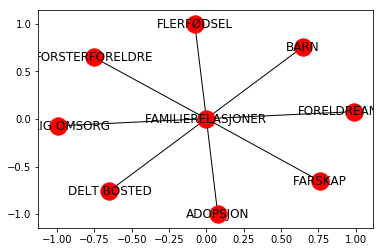

In [86]:
nx.draw_networkx(
    G=G,
    pos=pos
)

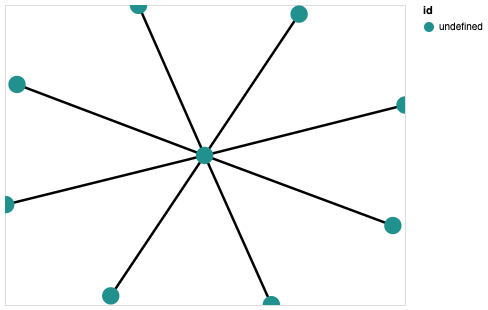

In [87]:
# Compute positions for viz.
pos = nx.spring_layout(G)

viz = nxa.draw_networkx(
    G, pos=pos,
    node_color='id:N',
    cmap='viridis',
    width='weight:N',
    edge_color='black',
    node_tooltip=['weight:N']
)

viz.interactive()